<a href="https://colab.research.google.com/github/sabaagizew/10Acadamey_week-3/blob/main/week3_sales_pridict_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%load_ext autoreload
%autoreload 2

In [88]:
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

# loading packages
# basic + dates 
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
import sys, os
import json
import requests
import time
import datetime as dt
from datetime import date, timedelta, datetime

from itertools import repeat
import itertools

import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as ss
from random import randint




In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
log = logging.getLogger()
log.info('check')

INFO:root:check


In [10]:
# Read Datas

store_file = '../data/store.csv'
test_file = '../data/test.csv'
train_file = '../data/train.csv'

In [11]:
store_file= pd.read_csv('drive/MyDrive/main/store.csv')

In [12]:
test_file= pd.read_csv('drive/MyDrive/main/test.csv')

In [13]:
train_file=pd.read_csv('drive/MyDrive/main/train.csv')

In [64]:
train_file["Date"]=pd.to_datetime(train_file["Date"], format='%Y/%m/%d', errors='coerce')
test_file["Date"]=pd.to_datetime(test_file["Date"], format='%Y/%m/%d', errors='coerce')

def holiday(x):
    if x in ['a','b','c']:
        return 1
    return 0
    
def day_month_year(df, col):
    days, months, years = [], [], []
    for datetime in df[col]:
        year, month, day = str(datetime).split(' ')[0].split('-')
        days.append(int(day))
        months.append(int(month))
        years.append(int(year))
    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
train_file['Holiday'] = train_file['StateHoliday'].apply(holiday)
test_file['Holiday'] = test_file['StateHoliday'].apply(holiday)

train_file['Holiday'] = train_file['Holiday'] | train_file['SchoolHoliday']
test_file['Holiday'] = test_file['Holiday'] | test_file['SchoolHoliday']

day_month_year(train_file, 'Date')
day_month_year(test_file, 'Date')

In [14]:
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [15]:
train_file['Date'] = pd.to_datetime(train_file['Date'])
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [16]:
store_file

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [17]:
store_file.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [18]:
train_file.head()
train_file.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [19]:
test_file.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [20]:
train_file

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [24]:
store_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [25]:
store_file.isna().any()

Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [26]:
store_file.isna().any() # is null

Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [27]:
store_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [28]:
store_file.isnull().sum() / store_file.shape[0] * 100.00

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

In [29]:
# No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values
store_file['CompetitionDistance'].fillna(store_file['CompetitionDistance'].median(), inplace = True)

In [30]:
store_file.fillna(0, inplace = True)
store_file.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [31]:
# To see the percentage of missing values of every columns
def every_column_percent_missing(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})

    missing_value_df.sort_values('percent_missing', inplace=True)

    print(missing_value_df)


every_column_percent_missing(store_file)

                                         column_name  percent_missing
Store                                          Store              0.0
StoreType                                  StoreType              0.0
Assortment                                Assortment              0.0
CompetitionDistance              CompetitionDistance              0.0
CompetitionOpenSinceMonth  CompetitionOpenSinceMonth              0.0
CompetitionOpenSinceYear    CompetitionOpenSinceYear              0.0
Promo2                                        Promo2              0.0
Promo2SinceWeek                      Promo2SinceWeek              0.0
Promo2SinceYear                      Promo2SinceYear              0.0
PromoInterval                          PromoInterval              0.0


In [32]:
## Store and Train
train_store = pd.merge(train_file, store_file, how='inner', on='Store')
train_store['StateHoliday'] = train_store['StateHoliday'].apply(lambda x: str(x))
train_store

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [33]:
#Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups


In [61]:
#plots
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, bins = 50, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_pie(df:pd.DataFrame, column:str, labels:list, title:str) -> None:
    df = df[[column]]
    sizes = [len(df[df[column] == val]) for val in set(df[column])]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title(title, size=15, fontweight='bold')
    ax1.axis('equal')
    plt.show()

def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()
    
def plot_monthly_sales(df, month, year, title):
    monthly_data = train_file[(train_file['Month'] == month) & (train_file['Year'] == year)][['Day','Sales']].groupby('Day').mean().reset_index()
    plot_bar(monthly_data, 'Day', 'Sales', title, 'Day', 'Sales')

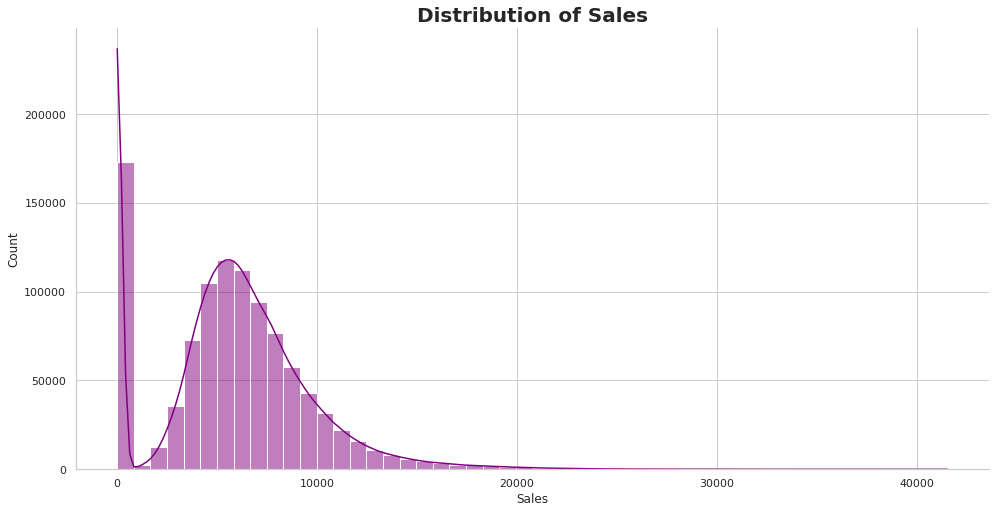

In [54]:
plot_hist(train_file, 'Sales', 'purple')

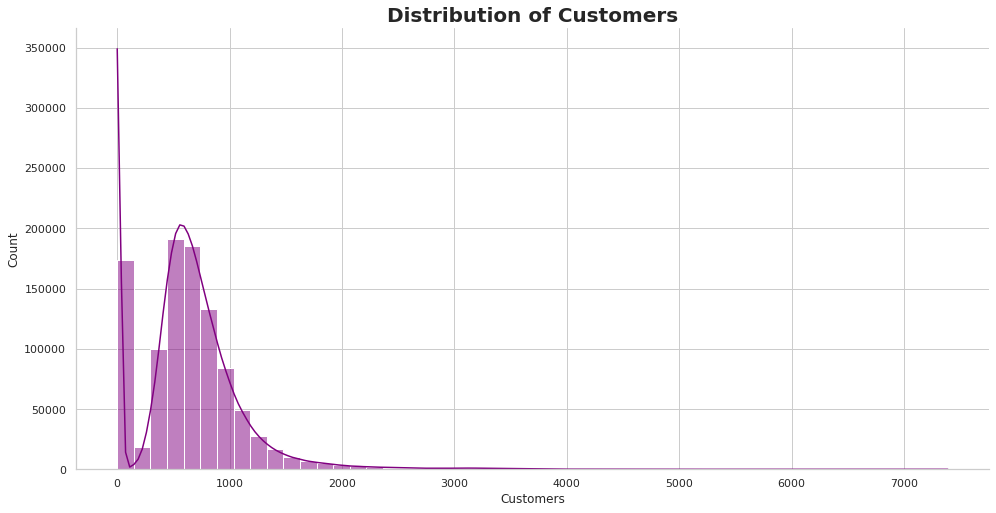

In [55]:
plot_hist(train_file, 'Customers', 'purple')

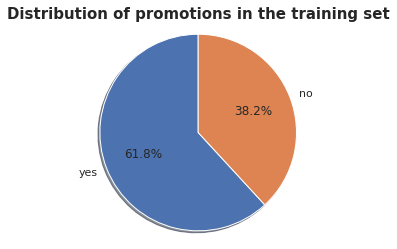

In [56]:
plot_pie(train_file, 'Promo', ['yes', 'no'], "Distribution of promotions in the training set")

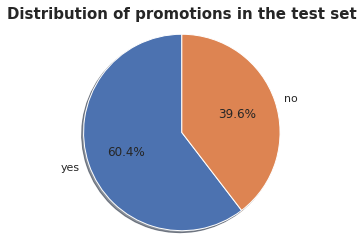

In [57]:
plot_pie(test_file, 'Promo', ['yes', 'no'], "Distribution of promotions in the test set")

In [ ]:
# Check & compare sales behavior before, during and after holidays


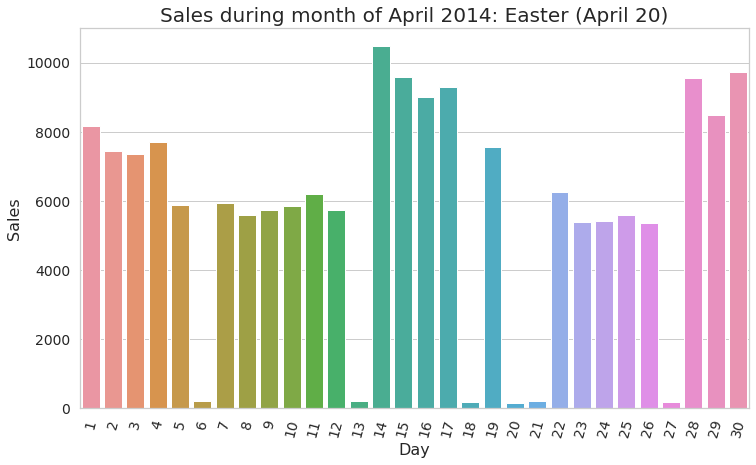

In [65]:
#sales behavior before  holidays
plot_monthly_sales(train_file, 4, 2014, 'Sales during month of April 2014: Easter (April 20)')

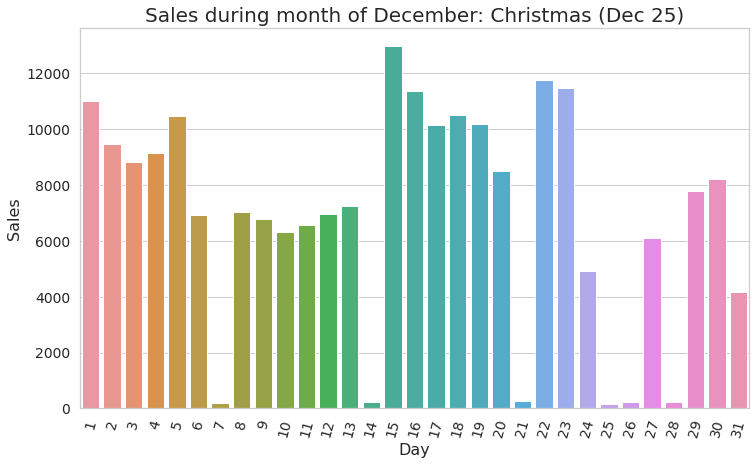

In [66]:
#sales behavior before  holidays
plot_monthly_sales(train_file, 12, 2014, 'Sales during month of December: Christmas (Dec 25)')

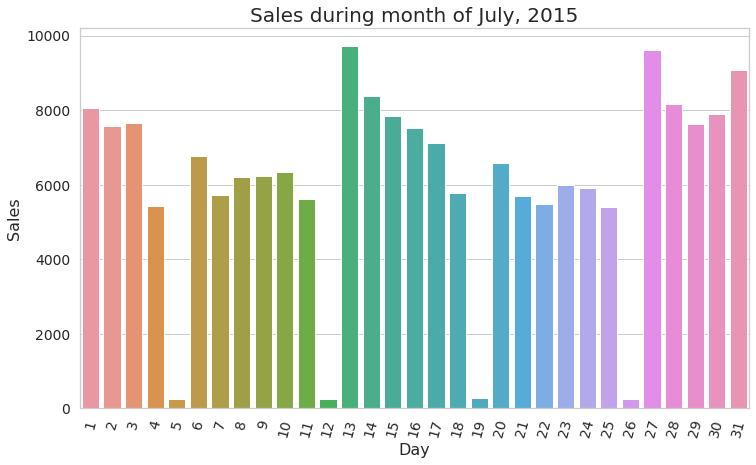

In [67]:
plot_monthly_sales(train_file, 7, 2015, 'Sales during month of July, 2015')

In [ ]:
#the correlation between sales and number of customers

In [71]:
train_file[['Customers','Sales']].corr()

,Customers,Sales
Customers,1.000000,0.894711
Sales,0.894711,1.000000


In [72]:
#Correlation between promo and sales
train_file[['Promo','Sales']].corr()

,Promo,Sales
Promo,1.000000,0.452345
Sales,0.452345,1.000000


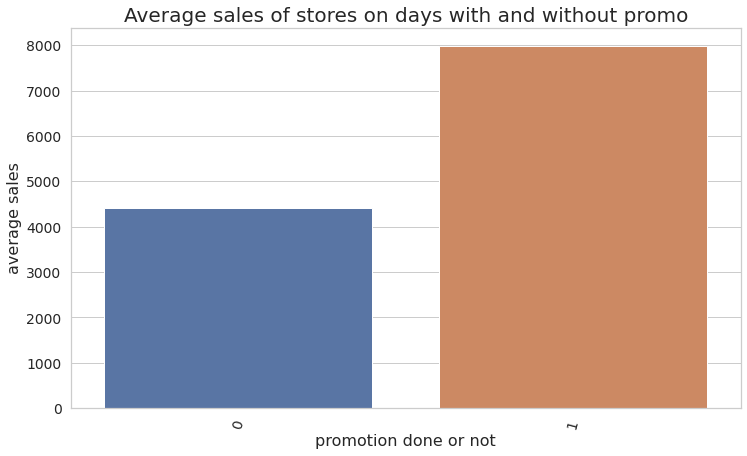

In [73]:
plot_bar(train_file[['Promo','Sales']].groupby('Promo').mean().reset_index(), 'Promo', 'Sales', 'Average sales of stores on days with and without promo', 'promotion done or not', 'average sales')

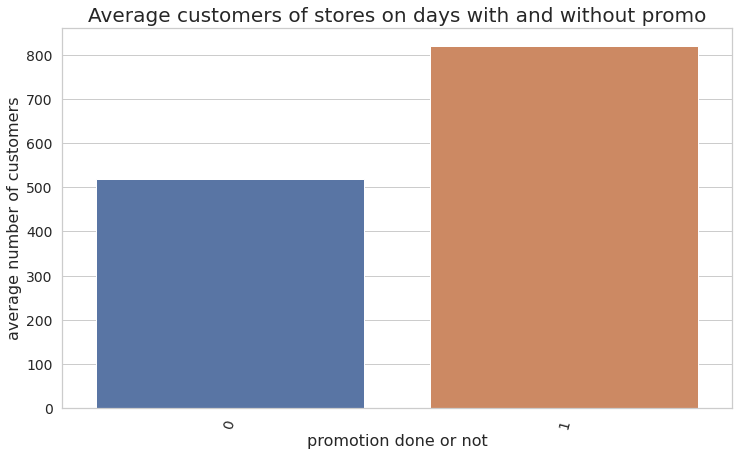

In [74]:
plot_bar(train_file[['Promo','Customers']].groupby('Promo').mean().reset_index(), 'Promo', 'Customers', 'Average customers of stores on days with and without promo', 'promotion done or not', 'average number of customers')

In [ ]:
#Existing customers return to buy more

In [ ]:
# Could the promos be deployed in more effective ways? Which stores should promos be deployed in?


In [77]:
df_promo = train_file[['Store', 'Promo', 'Sales']].groupby('Store').mean().sort_values(['Sales'], ascending=True).reset_index()
df_promo.describe()

,Store,Promo,Sales
count,1115.00000,1115.000000,1115.000000
mean,558.00000,0.381382,5763.320541
std,322.01708,0.001788,2046.447377
min,1.00000,0.377309,2244.503185
25%,279.50000,0.382166,4412.415567
50%,558.00000,0.382166,5459.185775
75%,836.50000,0.382166,6633.871550
max,1115.00000,0.382572,20718.515924


In [78]:
df_promo.head()

,Store,Promo,Sales
0,307,0.382166,2244.503185
1,543,0.382166,2313.468153
2,198,0.382166,2407.933121
3,208,0.382166,2443.791932
4,841,0.382166,2461.395966


In [79]:
df_promo['Sales'].quantile(0.20)

4221.443093625532

In [ ]:
#Percentage of days with promo seems to be almost the same for every store. It has a standard deviation of 0.001788

In [80]:
df_more_promos = df_promo[df_promo['Sales'] < df_promo['Sales'].quantile(0.20)]
df_more_promos.head()

,Store,Promo,Sales
0,307,0.382166,2244.503185
1,543,0.382166,2313.468153
2,198,0.382166,2407.933121
3,208,0.382166,2443.791932
4,841,0.382166,2461.395966


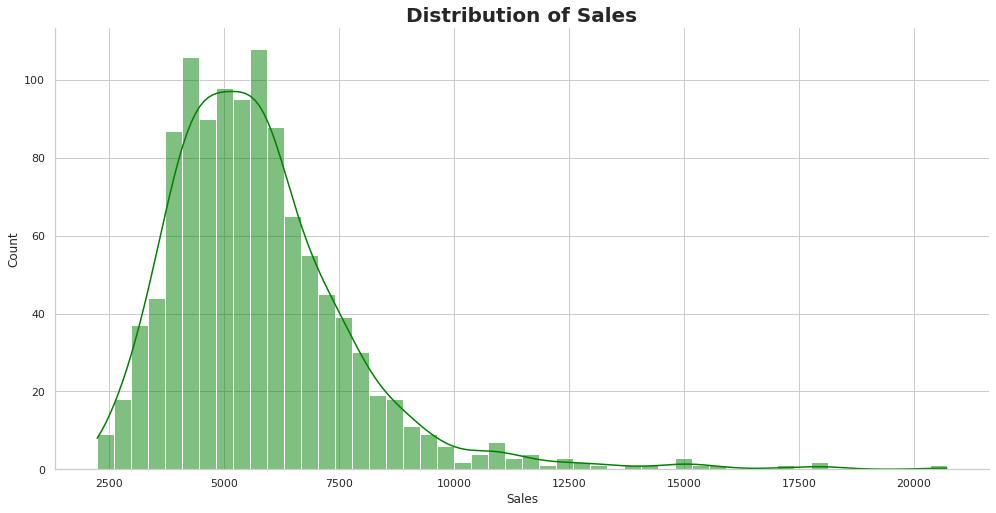

In [81]:
plot_hist(df_promo, 'Sales', 'green')

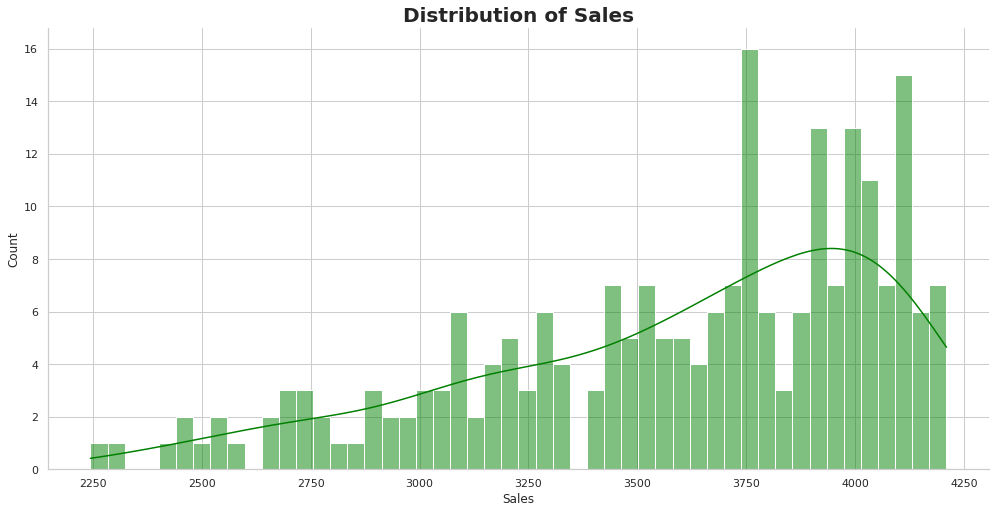

In [82]:
plot_hist(df_more_promos, 'Sales', 'green')

In [ ]:
# Trends of customer behavior during store open and closing times


<Figure size 864x504 with 0 Axes>

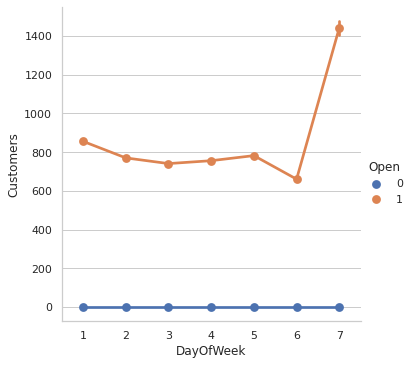

In [83]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="DayOfWeek", y = "Customers",
               hue = 'Open',
              sharex=False)

In [ ]:
# Which stores are opened on all weekdays? How does that affect their sales on weekends? 


Stores That work all Week are : 33


<Figure size 864x504 with 0 Axes>

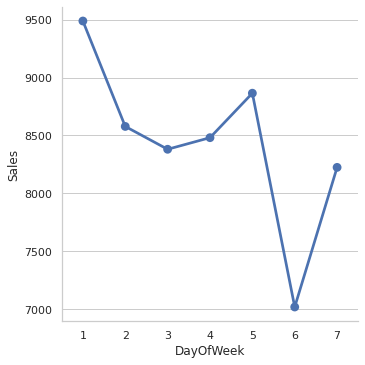

In [84]:
# stores, where their unique DayOfWeek count to 7
open_stores = train_store[train_store.Open == 1]
each_day = open_stores[['Store', 'DayOfWeek']].groupby('Store').nunique()

all_week_stores = each_day[each_day.DayOfWeek == 7]
stores_id = all_week_stores.reset_index()['Store']

get_stores = open_stores[(open_stores.Store.isin(set(stores_id)))]
get_stores = get_stores[['Store', 'Sales', 'Customers', 'DayOfWeek']]

week_sales = get_stores.groupby('DayOfWeek').mean().reset_index()

plt.figure(figsize=(12,7))
sns.factorplot(data = week_sales, x ="DayOfWeek", y = "Sales",
              sharex=False)
print(f'Stores That work all Week are : {all_week_stores.shape[0]}')

In [ ]:
#Average sale on Sunday exceeds the average sale on saturday.

In [ ]:
# Check how the assortment type affects sales


In [86]:
avg_sales = train_file[['Store','Sales']].groupby('Store').mean()
assortment_sales = avg_sales.join(store_file[['Store', 'Assortment']].set_index('Store'), on = 'Store')
assortment_sales.groupby('Assortment').mean()

,Sales
Assortment,
a,5468.451697
b,8485.838783
c,6056.409352


In [ ]:
#Stores with extra assortment levels have higher average turnover (earning)

In [ ]:
# How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, 
does the distance matter in that case?


In [92]:
avg_sales = train_file[['Store','Sales']].groupby('Store').mean()
comp_dist_sales = avg_sales.join(store_file[['Store', 'CompetitionDistance']].set_index('Store'), on = 'Store')
comp_dist_sales.sample(5)

,Sales,CompetitionDistance
Store,,
953,4419.259023,19830.0
186,3104.944591,290.0
256,8100.121019,80.0
981,6051.966030,2620.0
906,9061.332272,90.0


In [93]:
comp_dist_sales['decile_rank'] = pd.qcut(comp_dist_sales['CompetitionDistance'], 10, labels = False)
comp_dist_sales[['Sales','decile_rank']].groupby('decile_rank').mean()

,Sales
decile_rank,
0,6643.538689
1,5830.983842
2,5513.248212
3,5870.626481
4,5634.817297
5,5482.878158
6,5625.581049
7,5590.998641
8,5590.690430


In [ ]:
#The Distance to the next competitor is does not affect sales by much. In fact, the stores with the closest competitor have average higher sales earnings.